In [40]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [43]:
cares = pd.read_csv("../data/CARES_exclusion_cleaned.csv")
print(cares.shape)
cares.head()

(2167, 9)


,Unnamed: 0,GEO_ID,NAME,total_population,tract,N_corrected,CARES_exclusion,County,CARES_exclusion_c
0,0,1400000US36061000100,"Census Tract 1, New York County, New York",0,36061000100,3.679345,-inf,New York County,0.000000
1,1,1400000US36061000201,"Census Tract 2.01, New York County, New York",2835,36061000201,1352.964425,0.522764,New York County,0.522764
2,2,1400000US36061000202,"Census Tract 2.02, New York County, New York",7764,36061000202,6075.198137,0.217517,New York County,0.217517
3,3,1400000US36061000500,"Census Tract 5, New York County, New York",0,36061000500,NaN,NaN,New York County,0.000000
4,4,1400000US36061000600,"Census Tract 6, New York County, New York",9731,36061000600,8625.930297,0.113562,New York County,0.113562


In [44]:
cares["CARES_exclusion_n"] = cares["total_population"] - cares["N_corrected"]
cares["rank"] = cares['CARES_exclusion_n'].rank()
# larger residual population leads to higher ranker and greater risk
cares["bin"] = pd.cut(cares["rank"], 5, labels=[1,2,3,4,5])
cares.head()

,Unnamed: 0,GEO_ID,NAME,total_population,tract,N_corrected,CARES_exclusion,County,CARES_exclusion_c,CARES_exclusion_n,rank,bin
0,0,1400000US36061000100,"Census Tract 1, New York County, New York",0,36061000100,3.679345,-inf,New York County,0.000000,-3.679345,482.0,2
1,1,1400000US36061000201,"Census Tract 2.01, New York County, New York",2835,36061000201,1352.964425,0.522764,New York County,0.522764,1482.035575,1862.0,5
2,2,1400000US36061000202,"Census Tract 2.02, New York County, New York",7764,36061000202,6075.198137,0.217517,New York County,0.217517,1688.801863,1931.0,5
3,3,1400000US36061000500,"Census Tract 5, New York County, New York",0,36061000500,NaN,NaN,New York County,0.000000,NaN,NaN,NaN
4,4,1400000US36061000600,"Census Tract 6, New York County, New York",9731,36061000600,8625.930297,0.113562,New York County,0.113562,1105.069703,1663.0,4


In [45]:
file_path = "zip://../data/cb_2018_36_tract_500k.zip!cb_2018_36_tract_500k.shp"   # for windows
# file_path = "zip:../data/cb_2018_36_tract_500k.zip!cb_2018_36_tract_500k.shp"   # for mac maybe
tracks = gpd.read_file(file_path)

In [46]:
tracks.shape

(4906, 10)

In [47]:
tracksNYC = tracks.join(cares.set_index("GEO_ID"), on = "AFFGEOID", how = "right", rsuffix='d')
tracksNYC.shape

(2167, 21)

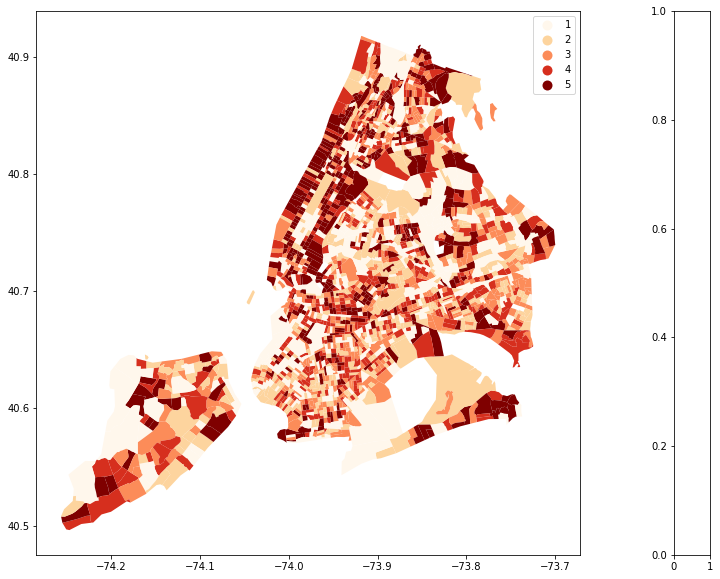

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)

tracksNYC.plot(column='bin', ax=ax, legend=True, cax=cax, cmap='OrRd')

In [63]:
acs_renter = pd.read_csv('../data/neighborhood_char/acs_summary.csv')
acs_renter.head()

,GEO_ID,non_high_school_per,college_per,med_income,renter_num,renter_per,mid_rent,rent_35,total_pop,latinx,white,black,asian,include
0,1400000US36081000100,1.8,79.5,142348.0,3642.0,87.7,3164.0,27.3,8830.0,8.2,58.8,3.9,22.8,1
1,1400000US36081000200,21.9,23.2,72813.0,415.0,44.4,1707.0,40.1,3208.0,70.0,11.7,1.2,16.1,0
2,1400000US36081000400,33.7,22.3,59423.0,633.0,53.3,1554.0,57.9,4583.0,67.0,4.4,2.8,23.2,1
3,1400000US36081000600,26.1,23.8,77407.0,388.0,40.2,1678.0,60.9,3690.0,64.6,10.4,3.3,20.5,0
4,1400000US36081000700,4.0,75.3,126935.0,1783.0,62.5,2223.0,31.3,6079.0,16.7,52.3,0.6,25.2,1


In [64]:
renterNYC = tracks.join(acs_renter.set_index("GEO_ID"), on="AFFGEOID", how = "right", rsuffix='r')

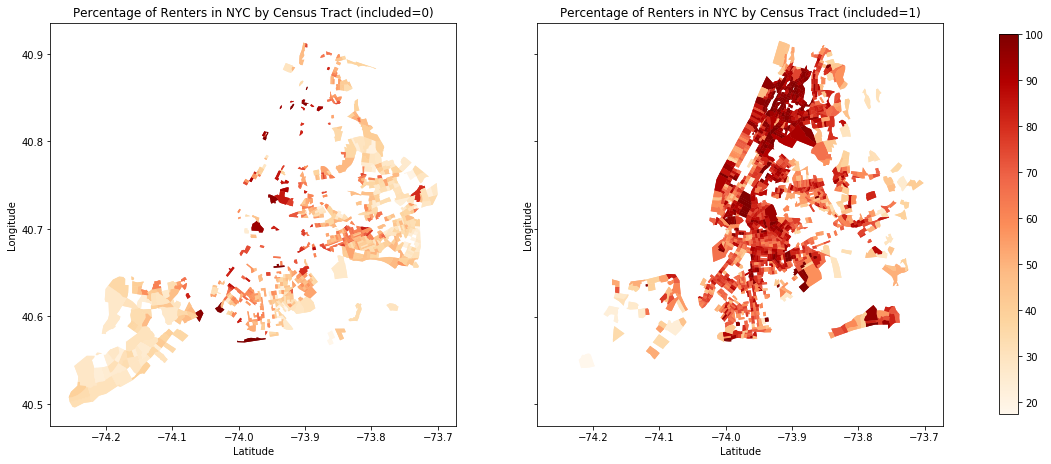

In [76]:
renterNYC['include'] = (renterNYC.renter_num>500)*1  # default threshold (UCLA) = 500
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
for i in range(2):
    renterNYC[renterNYC['include']==0].plot(column='renter_per', ax=ax[0], cmap='OrRd');
    renterNYC[renterNYC['include']==1].plot(column='renter_per', ax=ax[1], cmap='OrRd');
    ax[i].set_title('Percentage of Renters in NYC by Census Tract (included={})'.format(i));
    ax[i].set_xlabel('Latitude');
    ax[i].set_ylabel('Longitude');
patch_col = ax[1].collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.7)
fig.savefig('../output/renter_percentage.png', bbox_inches = 'tight')